# 檢視與處理 Outliers
### 為何會有 outliers, 常見的 outlier 原因
* 未知值，隨意填補 (約定俗成的代入)，如年齡常見 0,999
* 可能的錯誤紀錄/手誤/系統性錯誤，如某本書在某筆訂單的銷售量 = 1000 本

# [作業目標]
- 依照下列提示與引導, 以幾種不同的方式, 檢視可能的離群值

# [作業重點]
- 從原始資料篩選可能的欄位, 看看那些欄位可能有離群值 (In[3], Out[3])
- 繪製目標值累積密度函數(ECDF)的圖形, 和常態分布的累積密度函數對比, 以確認是否有離群值的情形 (In[6], Out[6], In[7], Out[7])

In [14]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# 設定 data_path
dir_data = '/Users/bananaiselite'

In [15]:
f_app = os.path.join(dir_data, 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: /Users/bananaiselite/application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 請參考 HomeCredit_columns_description.csv 的欄位說明，觀察並列出三個你覺得可能有 outlier 的欄位並解釋可能的原因

In [18]:
h_app = os.path.join(dir_data, 'HomeCredit_columns_description.csv')
HomeCredit_columns_description  = pd.read_csv(h_app, encoding = 'unicode_escape')
HomeCredit_columns_description.loc[:, 'Row':'Description']

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,Target variable (1 - client with payment diffi...
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
...,...,...
214,NUM_INSTALMENT_NUMBER,On which installment we observe payment
215,DAYS_INSTALMENT,When the installment of previous credit was su...
216,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...
217,AMT_INSTALMENT,What was the prescribed installment amount of ...


In [19]:
app_train_dtype =app_train.dtypes.reset_index()
app_train_dtype_count = app_train_dtype.groupby(0).agg('index').count().reset_index()
app_train_dtype_count.columns = ['dtype', 'count']
app_train_dtype_count

,dtype,count
0,int64,41
1,float64,65
2,object,16


Number of remain columns:73


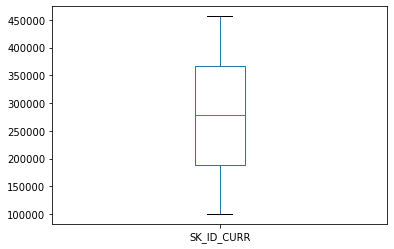

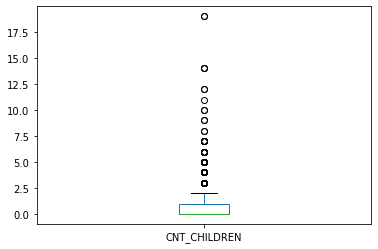

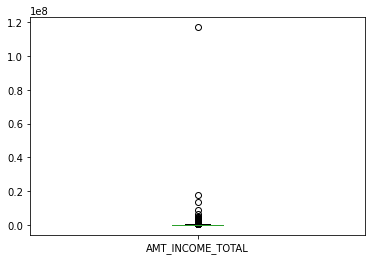

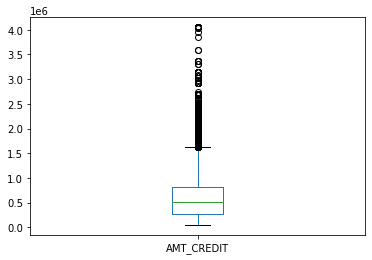

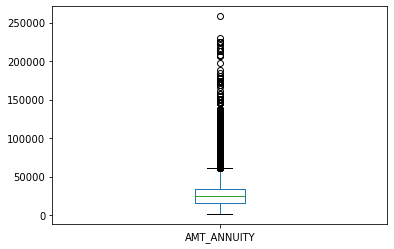

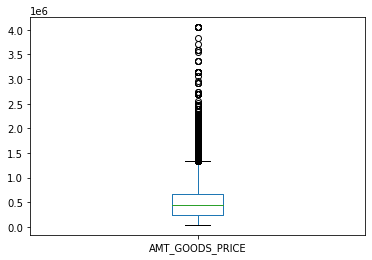

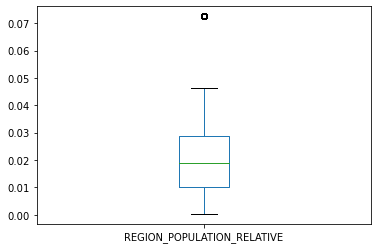

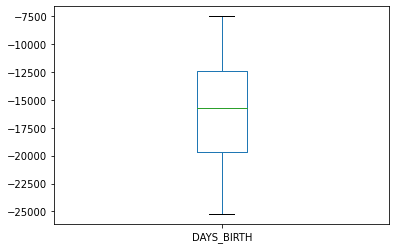

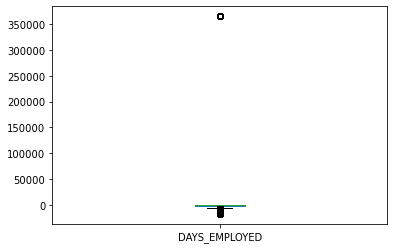

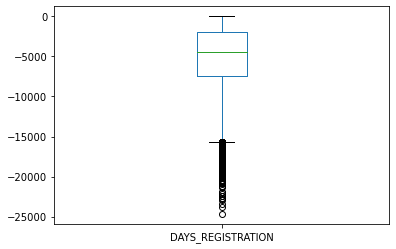

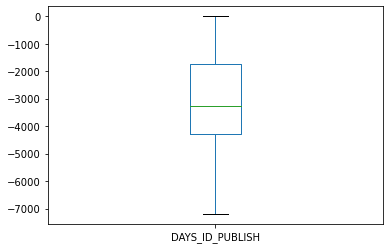

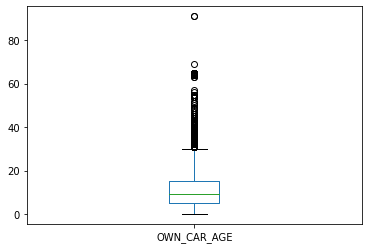

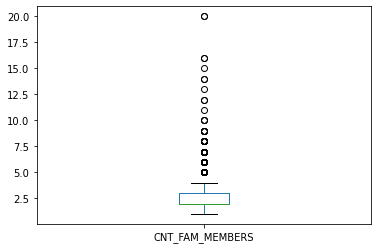

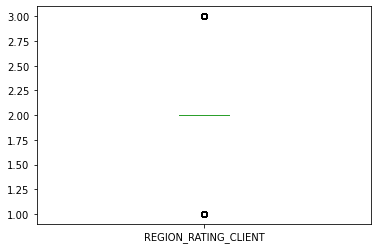

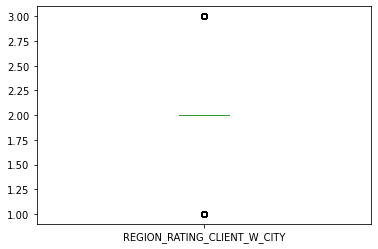

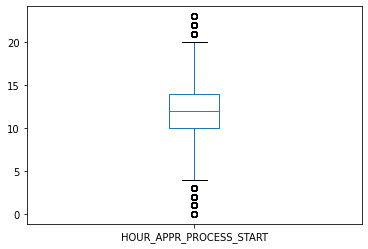

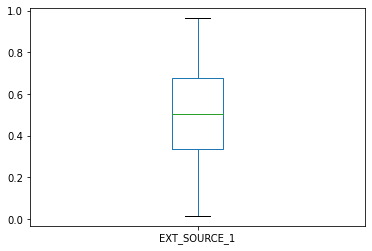

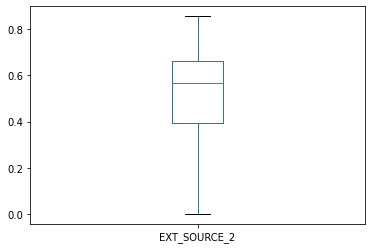

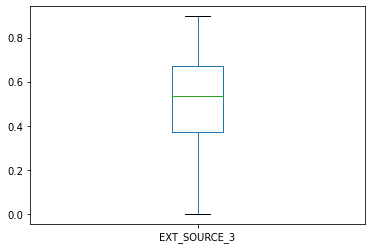

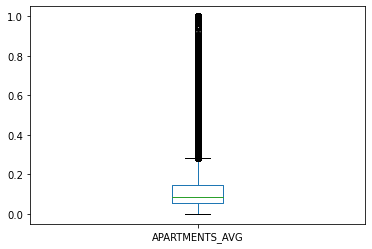

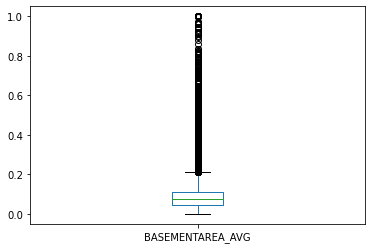

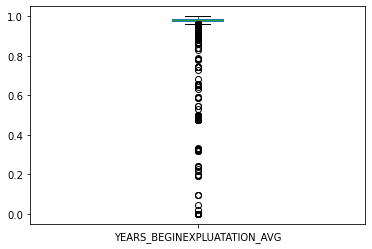

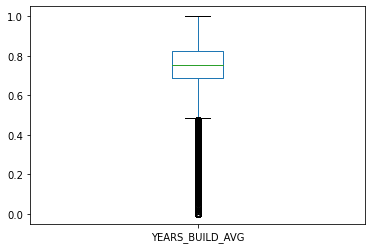

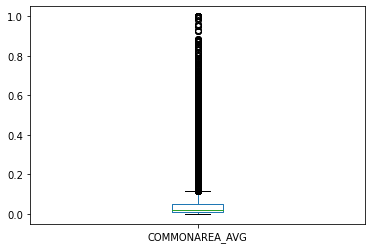

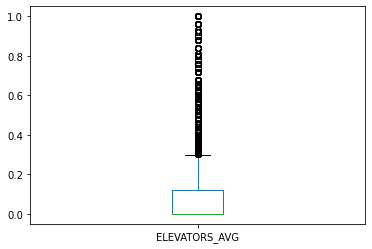

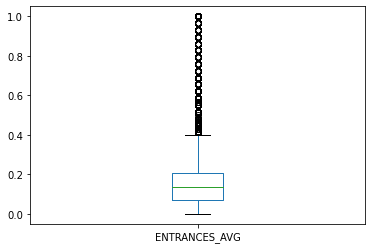

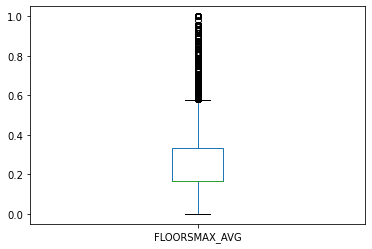

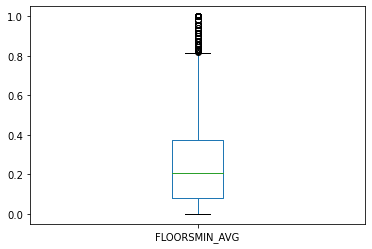

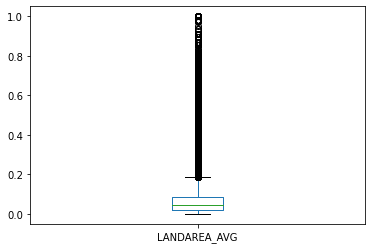

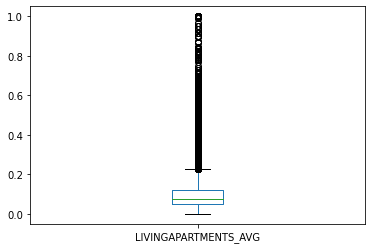

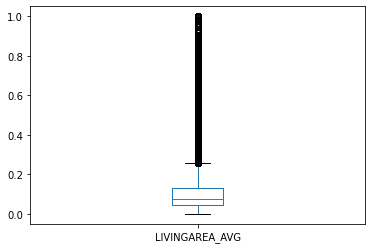

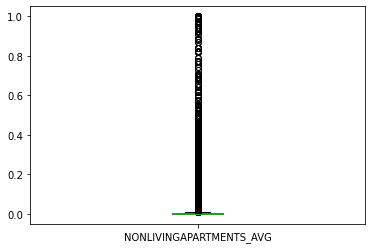

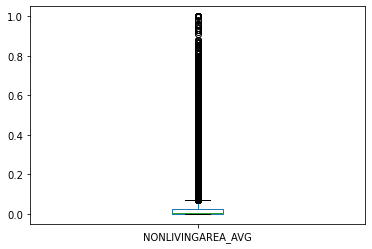

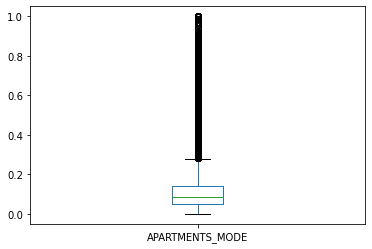

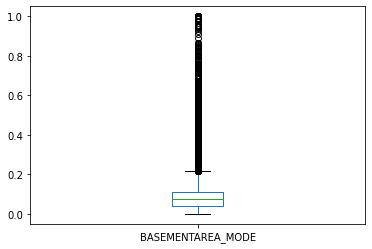

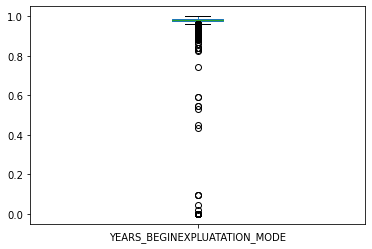

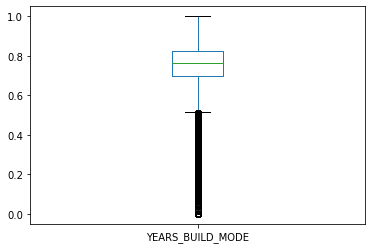

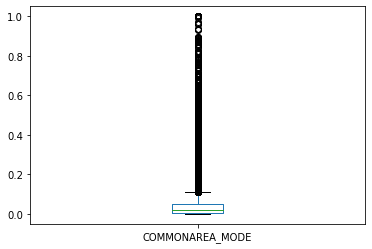

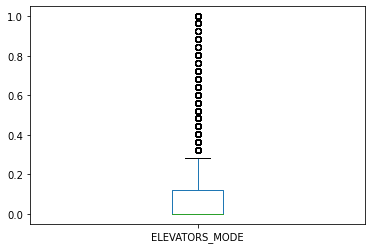

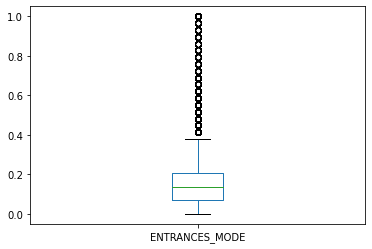

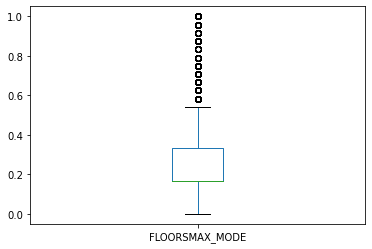

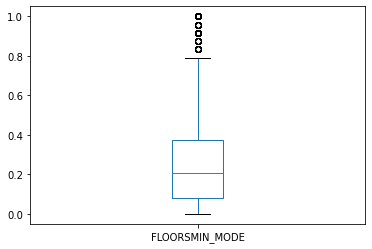

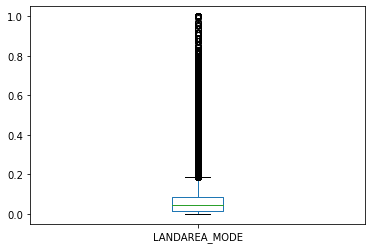

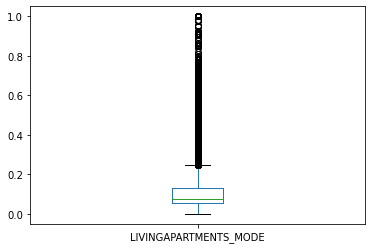

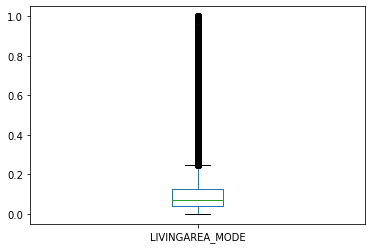

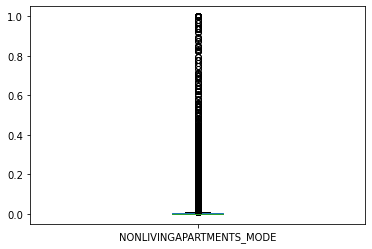

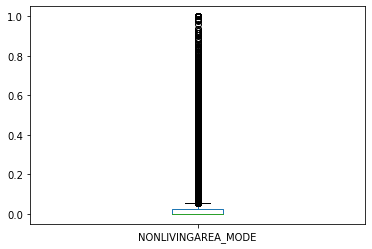

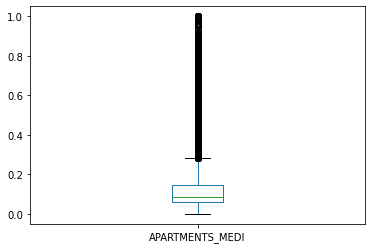

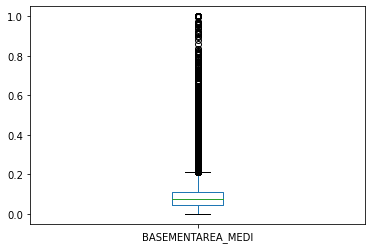

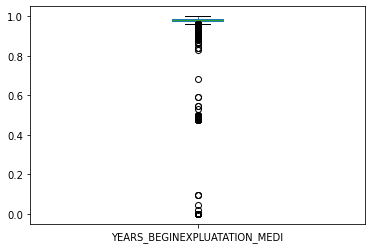

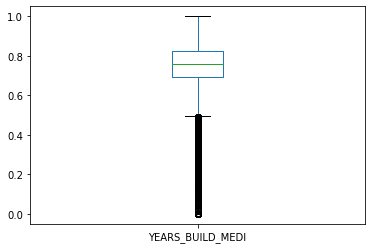

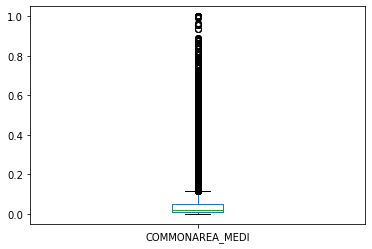

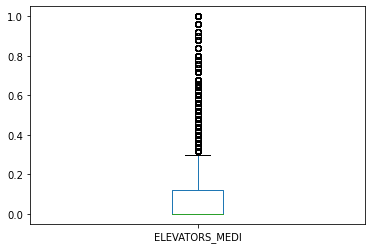

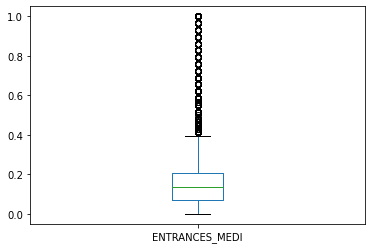

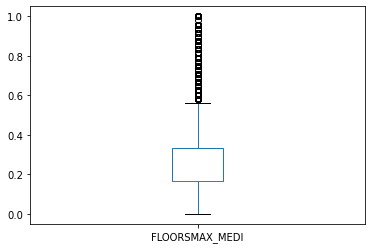

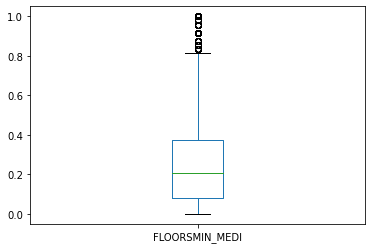

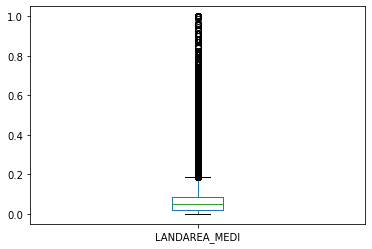

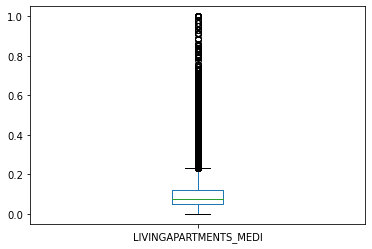

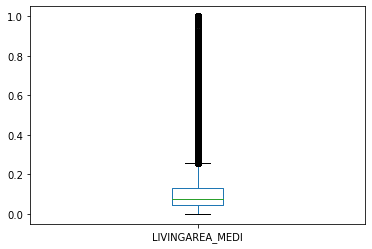

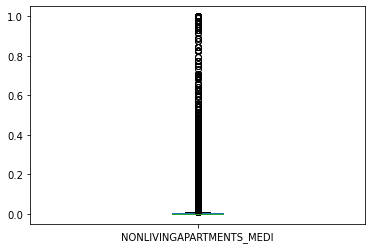

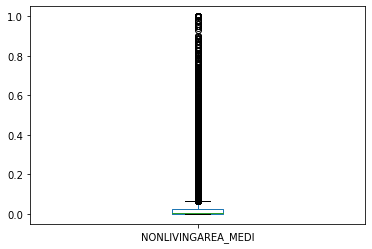

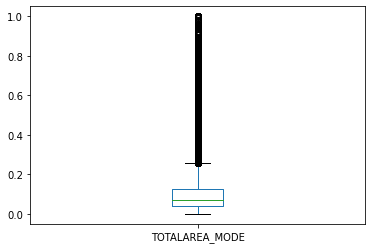

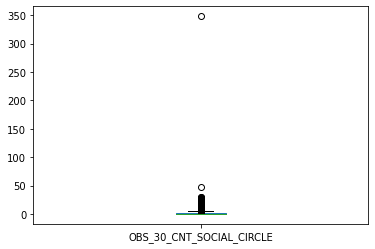

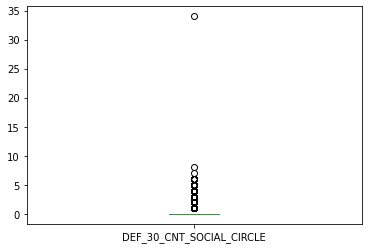

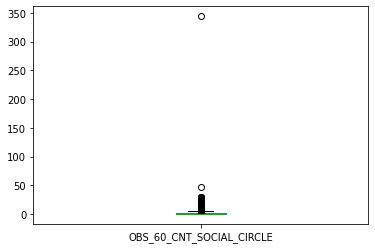

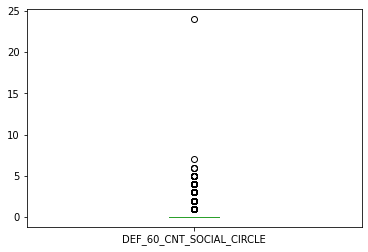

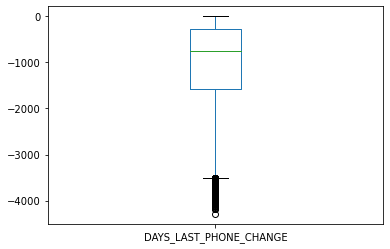

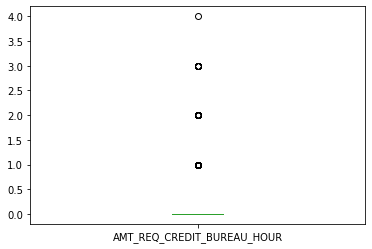

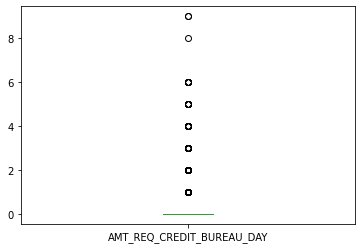

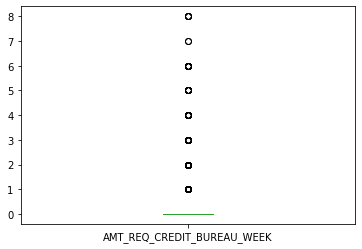

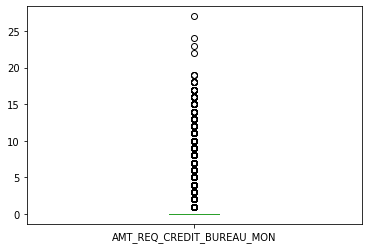

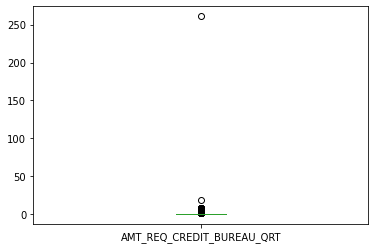

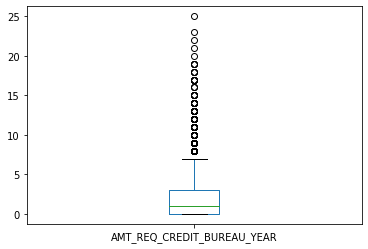

In [20]:
# 先篩選數值型的欄位

dtype_select = [_ for _ in app_train_dtype_count.loc[0:1, 'dtype']]

numeric_columns = list(app_train.columns[list(app_train.dtypes.isin(dtype_select))])

# 再把只有 2 值 (通常是 0,1) 的欄位去掉
numeric_columns = list(app_train[numeric_columns].columns[list(app_train[numeric_columns].apply(lambda x:len(x.unique())!=2 ))])
print(f'Number of remain columns:{len(numeric_columns)}')

# 檢視這些欄位的數值範圍
for col in numeric_columns:
    app_train[col].plot.box()
    plt.show()

從圖片檢查，發現有七個值有點可疑，分別是：
*  AMT_INCOME_TOTAL
*  AMT_REQ_CREDIT_BUREAU_QRT
*  REGION_POPULATION_RELATIVE
*  OBS_60_CNT_SOCIAL_CIRCLE
*  DEF_30_CNT_SOCIAL_CIRCLE
*  OBS_30_CNT_SOCIAL_CIRCLE
*  DAYS_EMPLOYED

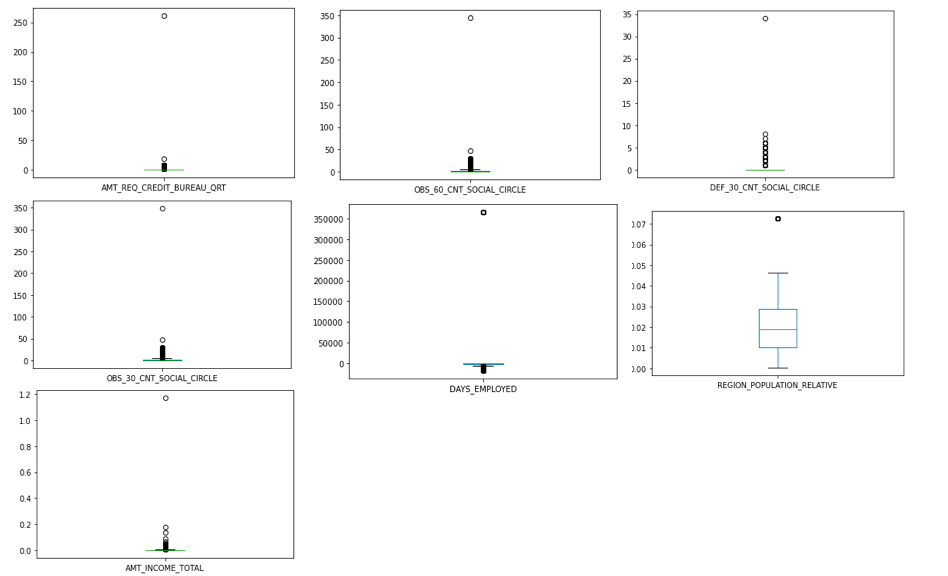

### Hints: Emprical Cumulative Density Plot, [ECDF](https://zh.wikipedia.org/wiki/%E7%BB%8F%E9%AA%8C%E5%88%86%E5%B8%83%E5%87%BD%E6%95%B0), [ECDF with Python](https://stackoverflow.com/questions/14006520/ecdf-in-python-without-step-function)

先來觀察一下AMT_INCOME_TOTAL這一行，從HomeCredit_columns_description中知道，這是客戶的收入

In [21]:
print(app_train['AMT_INCOME_TOTAL'].describe())

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64


再來定義離群值，從平均值向外延伸三個標準差之內，都算是可接受範圍
超出這範圍外的數值便用Nan換掉

In [30]:
from numpy import mean, std
cdf = pd.DataFrame(app_train['AMT_INCOME_TOTAL'].sort_values(axis=0)).reset_index()
del cdf['index']
data_mean, data_std = mean(cdf['AMT_INCOME_TOTAL']), std(cdf['AMT_INCOME_TOTAL'])
cut_off = 3*data_std
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
for i in app_train['AMT_INCOME_TOTAL']:
    if i < lower or i > upper:
        cdf.replace({i:np.nan}, inplace = True)

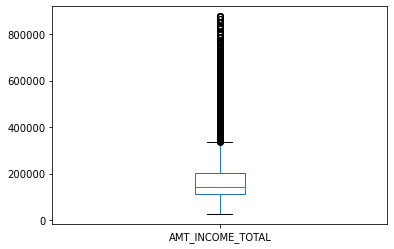

In [31]:
#再畫一張箱形圖觀察
cdf.plot.box()

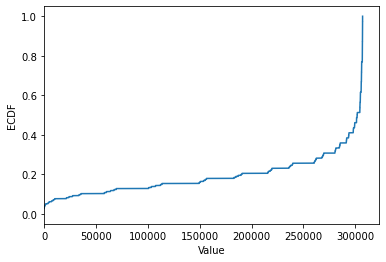

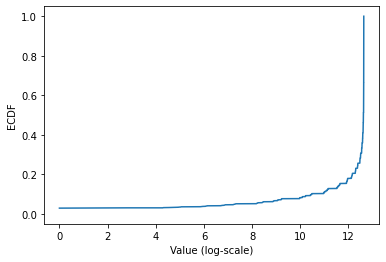

In [33]:
#強迫症發作，把警告濾掉
import warnings
warnings.filterwarnings("ignore")

plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([cdf.index.min(), cdf.index.max() * 1.05]) # 限制顯示圖片的範圍
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

# 改變 y 軸的 Scale, 讓我們可以正常檢視 ECDF
plt.plot(np.log(list(cdf.index)), cdf/cdf.max())
plt.xlabel('Value (log-scale)')
plt.ylabel('ECDF')

plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

## 補充：Normal dist 的 ECDF
![ecdf_normal](https://au.mathworks.com/help/examples/stats/win64/PlotEmpiricalCdfAndCompareWithSamplingDistributionExample_01.png)

       REGION_POPULATION_RELATIVE
count               307511.000000
mean                     0.020868
std                      0.013831
min                      0.000290
25%                      0.010006
50%                      0.018850
75%                      0.028663
max                      0.072508


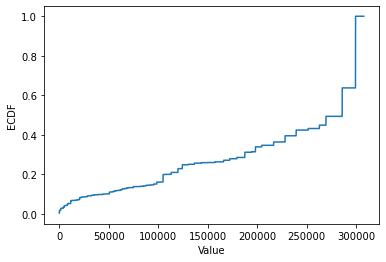

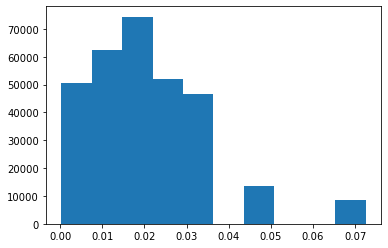

0.035792    16408
0.046220    13442
0.030755    12163
0.025164    11950
0.026392    11601
            ...  
0.001417      467
0.001333      235
0.000533       39
0.000938       28
0.000290        2
Name: REGION_POPULATION_RELATIVE, Length: 81, dtype: int64

In [38]:
# 最大值落在分布之外
RPR_cdf = pd.DataFrame(app_train['REGION_POPULATION_RELATIVE'].sort_values(axis=0)).reset_index()
del RPR_cdf['index']
RPR_cdf.describe()

print(RPR_cdf.describe())



plt.plot(list(RPR_cdf.index), RPR_cdf/RPR_cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

app_train['REGION_POPULATION_RELATIVE'].hist(grid = False)
plt.show()

app_train['REGION_POPULATION_RELATIVE'].value_counts()

# 就以這個欄位來說，雖然有資料掉在分布以外，也不算異常，僅代表這間公司在稍微熱鬧的地區有的據點較少，
# 導致 region population relative 在少的部分較為密集，但在大的部分較為疏漏

       OBS_60_CNT_SOCIAL_CIRCLE
count             306490.000000
mean                   1.405292
std                    2.379803
min                    0.000000
25%                    0.000000
50%                    0.000000
75%                    2.000000
max                  344.000000


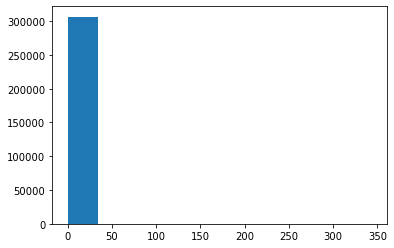

344.0         1
47.0          1
30.0          1
29.0          2
28.0          1
27.0          5
26.0          1
25.0         11
24.0         12
23.0         13
22.0         20
21.0         28
20.0         30
19.0         44
18.0         49
17.0         73
16.0        137
15.0        166
14.0        238
13.0        401
12.0        620
11.0        837
10.0       1335
9.0        1959
8.0        2886
7.0        4344
6.0        6349
5.0        9463
4.0       13946
3.0       20215
2.0       29766
1.0       48870
0.0      164666
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64


In [42]:
# 最大值落在分布之外
OBS_60_cdf  = app_train['OBS_60_CNT_SOCIAL_CIRCLE'].sort_values(axis = 0).reset_index()
del OBS_60_cdf['index']
print(OBS_60_cdf.describe())

"""
plt.plot(list(OBS_60_cd.index), OBS_60_cd/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([OBS_60_cd.index.min() * 0.95, OBS_60_cd.index.max() * 1.05])
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()
"""
OBS_60_cdf['OBS_60_CNT_SOCIAL_CIRCLE'].hist(grid = False)
plt.show()
print(OBS_60_cdf['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index(ascending = False))

## 注意：當 histogram 畫出上面這種圖 (只出現一條，但是 x 軸延伸很長導致右邊有一大片空白時，代表右邊有值但是數量稀少。這時可以考慮用 value_counts 去找到這些數值

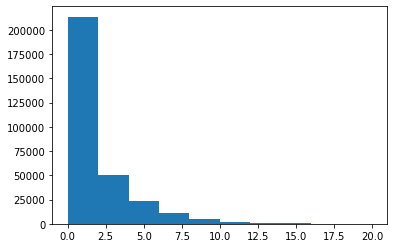

In [65]:
# 把一些極端值暫時去掉，在繪製一次 Histogram
# 選擇 OBS_60_CNT_SOCIAL_CIRCLE 小於 20 的資料點繪製

OBS_60_cdf[OBS_60_cdf['OBS_60_CNT_SOCIAL_CIRCLE']  < 21]['OBS_60_CNT_SOCIAL_CIRCLE'].hist( grid = False)
plt.show()